# Data download

In [1]:
# API reference: https://pypi.org/project/binance-historical-data/#create-file-name-for-the-local-file
# pip install binance_historical_data
import datetime
from binance_historical_data import BinanceDataDumper
import pandas as pd
import os
import glob

In [2]:
class DataFetch:
    def __init__(self, date_end, frequency, dump_url, base_directory, output_directory):
        self.date_end = date_end
        self.frequency = frequency
        self.dump_url = dump_url
        self.base_directory = base_directory
        self.output_directory = output_directory
        
        # initialize main object: data_dumper
        self.data_dumper = BinanceDataDumper(
            path_dir_where_to_dump=self.dump_url,
            asset_class="spot",  # spot, um, cm
            data_type="klines",  # aggTrades, klines, trades
            data_frequency=self.frequency, # [1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h]
        )
    
    def fetch_min_start_date_list(self, date_end):
        """Check minutes starting date"""
        all_trading_pairs = self.data_dumper.get_list_all_trading_pairs() # list
        potential_trading_pairs = []

        for i in all_trading_pairs:
            date = self.data_dumper.get_min_start_date_for_ticker(i) # get_min_start_date_for_ticker()
            if date < date_end: # filter start date
                potential_trading_pairs.append([i, date])
                print(f'Add {i}, Start date {date}')

        latest_date = max(potential_trading_pairs, key=lambda x: x[1])
        trading_pairs_list = [x[0] for x in potential_trading_pairs]

        return potential_trading_pairs, latest_date[1], trading_pairs_list
    
    def check_min_start_date(self, trading_pairs_list, date_end):
        potential_trading_pairs = []
        for i in trading_pairs_list:
            date = self.data_dumper.get_min_start_date_for_ticker(i) # get_min_start_date_for_ticker()
            potential_trading_pairs.append([i, date])
            print(f'Add {i}, Start date {date}')
            
        latest_date = max(potential_trading_pairs, key=lambda x: x[1])
        
        return latest_date[1]
    
    def download_hist_data(self, trading_pairs_list, date_start):
        """Download trading pairs historical data"""
        # dump the data
        self.data_dumper.dump_data(
            tickers=trading_pairs_list,
            date_start=date_start,
            date_end=None, # if equals to None - Today’s date will be used
            is_to_update_existing=True, # (bool) Flag if you want to update the data if it’s already exist
            tickers_to_exclude=["UST"],
        )
        return

    def concatenate_hist_data(self, trading_pairs_list, date_start, base_directory, output_directory):
        """Concatenate historical data"""
        # define the desired column names
        column_names = ["Open time", "Open", "High", "Low", "Close", "Volume", "Close time", 
                        "Quote asset volume", "Number of trades", "Taker buy base asset volume", 
                        "Taker buy quote asset volume", "Ignore"]

#         # get the list of all subdirectories
#         all_subdirs = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
        
        # define a list of specific subdirectories want to process
        specific_subdirs = trading_pairs_list
        
        # loop over the list of specific subdirectories
        for subdir in specific_subdirs:
            directory = os.path.join(base_directory, subdir, self.frequency)  # include the '1m' subdirectory

            # get the list of all csv files
#             all_files = glob.glob(os.path.join(directory, "*.csv"))
            all_files = glob.glob(directory + "/*.csv")

            # if no CSV file or only one CSV file, skip the concatenation
            if len(all_files) <= 1:
                print(f"Skipped directory {directory}: Found {len(all_files)} CSV file(s).")
                continue

            # initialize an empty list to store the dataframes
            df_list = []

            # loop over the list of files
            for filename in all_files:
                df = pd.read_csv(filename, names=column_names) # read the csv file into a pandas DataFrame, set the column names and append it to df_list
#                 df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
#                 df['Close time'] = pd.to_datetime(df['Close time'], unit='ms') # convert the 'Open time' ('Close time') column to datetime format
                df_list.append(df)

            final_df = pd.concat(df_list) # concatenate all the dataframes in the list
            final_df.to_csv(os.path.join(output_directory, f'{subdir}.csv')) # save the final dataframe to a new csv file in the output directory with the name of the subdirectory
            print(f'{subdir}.csv Saved')
        return
    
    def update_data(self):
        return
    
#     def fetch_single(self, pair_name_list, date_start):
#         self.download_hist_data(pair_name_list, date_start)
#         self.concatenate_hist_data(pair_name_list, date_start, self.base_directory, self.output_directory)
#         return
    
    def fetch_all(self, trading_pairs_list, date_start):
        self.download_hist_data(trading_pairs_list, date_start)
        self.concatenate_hist_data(trading_pairs_list, date_start, self.base_directory, self.output_directory)
        return
        
        

In [3]:
date_end = datetime.date(2022, 6, 1)
frequency = "30m"
dump_url = "/Users/youranpan/Desktop/PKU Quantitative Strategy Research Intern/Local_Strategy_Backtest/historical_data"
base_directory = "/Users/youranpan/Desktop/PKU Quantitative Strategy Research Intern/Local_Strategy_Backtest/historical_data/spot/monthly/klines"
output_directory = "/Users/youranpan/Desktop/PKU Quantitative Strategy Research Intern/Local_Strategy_Backtest/historical_data/concatenate_data"

Data_Fetch = DataFetch(date_end, frequency, dump_url, base_directory, output_directory)
# potential_trading_pairs, date_start, trading_pairs_list = Data_Fetch.fetch_min_start_date_list(date_end)

pairs_list = ['ETHUSDT', 'BTCUSDT', 'ADAUSDT', 'BNBUSDT', 'DOGEUSDT', 'ETCUSDT', 'LTCUSDT', 'MATICUSDT', 'XRPUSDT']

date_start = Data_Fetch.check_min_start_date(pairs_list, date_end)
Data_Fetch.download_hist_data(pairs_list, date_start)
Data_Fetch.concatenate_hist_data(pairs_list, date_start, base_directory, output_directory)

Add ETHUSDT, Start date 2017-08-01
Add BTCUSDT, Start date 2017-08-01
Add ADAUSDT, Start date 2018-04-01
Add BNBUSDT, Start date 2017-11-01
Add DOGEUSDT, Start date 2019-07-01
Add ETCUSDT, Start date 2018-06-01
Add LTCUSDT, Start date 2017-12-01
Add MATICUSDT, Start date 2019-04-01
Add XRPUSDT, Start date 2018-05-01
---> Found overall tickers: 522
---> Filter to asked tickers: 9
------> Tickers left: 9
---> Exclude the asked tickers: 1
------> Tickers left: 9
Download full data for 9 tickers: 
---> Data will be saved here: /Users/youranpan/Desktop/PKU Quantitative Strategy Research Intern/Local_Strategy_Backtest/historical_data/spot
---> Data Frequency: 30m
---> Start Date: 20190701
---> End Date: 20230605


Tickers:   0%|          | 0/9 [00:00<?, ?it/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

monthly files to download:   0%|          | 0/47 [00:00<?, ?files/s]

daily files to download:   0%|          | 0/4 [00:00<?, ?files/s]

Tried to dump data for 9 tickers:
---> For BTCUSDT new data saved for: 46 months 4 days
---> For ETHUSDT new data saved for: 46 months 4 days
---> For XRPUSDT new data saved for: 46 months 4 days
---> For LTCUSDT new data saved for: 46 months 4 days
---> For BNBUSDT new data saved for: 46 months 4 days
---> For ADAUSDT new data saved for: 46 months 4 days
---> For ETCUSDT new data saved for: 46 months 4 days
---> For DOGEUSDT new data saved for: 46 months 4 days
---> For MATICUSDT new data saved for: 46 months 4 days
ETHUSDT.csv Saved
BTCUSDT.csv Saved
ADAUSDT.csv Saved
BNBUSDT.csv Saved
DOGEUSDT.csv Saved
ETCUSDT.csv Saved
LTCUSDT.csv Saved
MATICUSDT.csv Saved
XRPUSDT.csv Saved


# Data prepare

In [4]:
import pandas as pd
import os
import glob
from datetime import datetime

import matplotlib.pyplot as plt

In [5]:
class DataPrepare:
    def __init__(self, trading_pairs_list, base_directory, concatenate_data_directory):
        self.trading_pairs_list = trading_pairs_list
        self.base_directory = base_directory
        self.concatenate_data_directory = concatenate_data_directory
        return
      
    def concatenate(self):
        
        column_names = ["Open time", "Open", "High", "Low", "Close", "Volume", "Close time", 
                        "Quote asset volume", "Number of trades", "Taker buy base asset volume", 
                        "Taker buy quote asset volume", "Ignore"]
        
        specific_files = self.trading_pairs_list

        df_list = []
        for file_name in specific_files:
            file_path = os.path.join(self.base_directory, file_name+'.csv')

            if not os.path.exists(file_path):
                print(f"File {file_path} does not exist.")
                continue

#             df = pd.read_csv(file_path, names=column_names)
            df = pd.read_csv(file_path)

            df['Trading pair'] = file_name

            df_list.append(df)

        final_df = pd.concat(df_list) # the concatenated dataframe
        
#         final_df['Open time'] = pd.to_datetime(final_df['Open time']) # convert 'Open time' column to datetime
        
        final_df['Open time'] = final_df['Open time'].astype(float) # convert into int

        final_df = final_df.sort_values(by='Open time') # sort by "Open time" column

        final_df = final_df.reset_index().dropna(subset=['index']).set_index('index') # remove NaN indexed data
        
#         final_df = final_df.drop('level_0', axis=1) # remove uncorrelated columns
        final_df = final_df.drop('Unnamed: 0', axis=1)
        
        final_df.to_csv(os.path.join(self.base_directory, "concatenated.csv"))
        return
    
    def read_concatenated(self):
        # add try: except
        final_df = pd.read_csv(self.concatenate_data_directory)
        return final_df
    
    def get_data_by_name(self, trading_pair_name):
        final_df = self.read_concatenated()
        mask = final_df['Trading pair'] == trading_pair_name
        filtered_df = final_df[mask]
        filtered_df = filtered_df.reset_index().dropna(subset=['index']).set_index('index')
        return filtered_df
    
    def get_data_by_time(self, specific_date):
        """
        specific_date: in datetime.dateime()
        """
        specific_date = specific_date.timestamp()*1000 # convert datetime.datetime into Unix timestamp
        final_df = self.read_concatenated()
        mask = final_df['Open time'] == int(specific_date)
        filtered_df = final_df[mask]
        filtered_df = filtered_df.reset_index().dropna(subset=['index']).set_index('index')
        return filtered_df
    
    def get_data_by_pair(self, pair_name_1, pair_name_2):
        """return paired dataframe"""
        final_df = self.read_concatenated()
        
        # get data respectively
        pair_name_1_df = self.get_data_by_name(pair_name_1)
        pair_name_2_df = self.get_data_by_name(pair_name_2)
        
        
        selected_columns = ["Open time", "Open", "High", "Low", "Close"]
        # pick specific columns
        pair_name_1_df = pair_name_1_df[selected_columns]
        pair_name_2_df = pair_name_2_df[selected_columns]
        
        # rename
        pair_name_1_df_renamed = pair_name_1_df.rename(columns={
                                 "Open": f'{pair_name_1}_Open',
                                 "High": f'{pair_name_1}_High',
                                 "Low": f'{pair_name_1}_Low',
                                 "Close": f'{pair_name_1}_Close'
        })
        pair_name_2_df_renamed = pair_name_2_df.rename(columns={
                                 "Open": f'{pair_name_2}_Open',
                                 "High": f'{pair_name_2}_High',
                                 "Low": f'{pair_name_2}_Low',
                                 "Close": f'{pair_name_2}_Close'
        })
                       
        # merge on a common column
        paired_df = pair_name_1_df_renamed.merge(pair_name_2_df_renamed, on='Open time')
        
        return paired_df
    
    def statistics(self):
        """return statistics of the selected cryptocurrency"""
        return # stats_df

In [6]:
pairs_list = ['ETHUSDT', 'BTCUSDT', 'ADAUSDT', 'BNBUSDT', 'DOGEUSDT', 'ETCUSDT', 'LTCUSDT', 'MATICUSDT', 'XRPUSDT']

base_directory = "/Users/youranpan/Desktop/PKU Quantitative Strategy Research Intern/Local_Strategy_Backtest/historical_data/concatenate_data"
concatenate_data_directory = "/Users/youranpan/Desktop/PKU Quantitative Strategy Research Intern/Local_Strategy_Backtest/historical_data/concatenate_data/concatenated.csv"

Data_Prepare = DataPrepare(pairs_list, base_directory, concatenate_data_directory)
Data_Prepare.concatenate()

# # read local concatenated .csv file
# df = Data_Prepare.read_concatenated()
# df

# # return specific date's data
# df = Data_Prepare.get_data_by_time(datetime.datetime(2019, 7, 1, 0, 30, 0))
# df

# # return specific symbol's data
# df = Data_Prepare.get_data_by_name('ETHUSDT')
# df

# return paired data
df = Data_Prepare.get_data_by_pair('ETHUSDT', 'BTCUSDT')
df


,Open time,ETHUSDT_Open,ETHUSDT_High,ETHUSDT_Low,ETHUSDT_Close,BTCUSDT_Open,BTCUSDT_High,BTCUSDT_Low,BTCUSDT_Close
0,1.561939e+12,292.89,295.39,289.61,293.27,10854.10,11047.01,10719.00,11000.15
1,1.561941e+12,293.39,297.30,291.67,296.94,11007.65,11104.41,10906.51,11091.54
2,1.561943e+12,297.09,300.74,296.07,297.43,11091.06,11171.42,10981.01,11043.70
3,1.561945e+12,297.49,299.42,295.45,296.40,11043.72,11110.00,10958.31,10973.34
4,1.561946e+12,296.48,299.50,294.12,298.80,10981.15,11090.00,10868.00,11081.18
...,...,...,...,...,...,...,...,...,...
67098,1.682890e+12,1896.77,1897.10,1891.36,1894.19,29472.61,29486.50,29359.34,29411.21
67099,1.682892e+12,1894.18,1895.56,1891.48,1894.43,29411.21,29430.00,29377.62,29418.12
67100,1.682894e+12,1894.42,1895.16,1890.00,1892.39,29418.11,29432.15,29367.15,29378.72
67101,1.682896e+12,1892.39,1893.25,1884.40,1889.30,29378.72,29420.23,29328.16,29391.74


# Benchmark

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [8]:
class Distance:
    def __init__(self, df, pair1, pair2, cash, transaction_cost):
        self.df = df.copy()
        self.pair1_Close = pair1+'_Close'
        self.pair2_Close = pair2+'_Close'
        self.cash = cash
        self.transaction_cost = transaction_cost
        
        self.returns = 0
        self.returns_list = []
        
    def generate_spread(self):
        scaler = StandardScaler()
        self.df[[self.pair1_Close, self.pair2_Close]] = scaler.fit_transform(self.df[[self.pair1_Close, self.pair2_Close]]) # standardize the price series
        self.df['spread'] = self.df[self.pair1_Close] - self.df[self.pair2_Close] # calculate the distance between the two series
        return

    def generate_signals(self, rolling_window):
        self.generate_spread()
        # generate trading signals based on the spread
        # threshold = self.df['spread'].rolling(rolling_window).mean() +- 2*self.df['spread'].rolling(rolling_window).std()
        self.df['long_signal'] = (self.df['spread'] > self.df['spread'].rolling(rolling_window).mean() + 2*self.df['spread'].rolling(rolling_window).std())
        self.df['short_signal'] = (self.df['spread'] < self.df['spread'].rolling(rolling_window).mean() - 2*self.df['spread'].rolling(rolling_window).std())
        return
    
    def trading_amount(self, close_1, close_2):
        return

    def execute_trades(self):
        # Placeholder function for executing trades, to be replaced with real trading logic
#         self.df['trade'] = ''
#         self.df.loc[self.df['long_signal'], 'trade'] = 'Go long on ' + self.pair1_Close + ', short on ' + self.pair2_Close
#         self.df.loc[self.df['short_signal'], 'trade'] = 'Go short on ' + self.pair1_Close + ', long on ' + self.pair2_Close
        
        for i in range(len(self.df)):
            if self.df.iloc[i]['long_signal']:
                curr_return = (self.df.iloc[i][self.pair1_Close]-self.transaction_cost)*10 - (self.df.iloc[i][self.pair2_Close]-self.transaction_cost)*10
                self.returns += curr_return
            elif self.df.iloc[i]['short_signal']:
                curr_return = (self.df.iloc[i][self.pair2_Close]-self.transaction_cost)*10 - (self.df.iloc[i][self.pair1_Close]-self.transaction_cost)*10
                self.returns += curr_return
            curr_return = self.returns
            self.returns_list.append(curr_return)
        
        self.returns_f()
        
        return self.df
    
    def returns_f(self):
        self.df['return'] = self.returns_list
        return
    
    def plot_result(self):
        self.df[self.pair1_Close].plot()
        self.df[self.pair2_Close].plot()
        plt.show()

        self.df['spread'].plot()
        plt.show()

        self.df['return'].plot()
        plt.show()
        return

In [9]:
pair1 = 'ETHUSDT'
pair2 = 'BTCUSDT'
cash = 10000
transaction_cost = 0.025

df = Data_Prepare.get_data_by_pair(pair1, pair2)

trader = Distance(df, pair1, pair2, cash, transaction_cost)
trader.generate_signals(rolling_window = 10) # 2 & 5 doesnt work
df1 = trader.execute_trades()
# trader.returns_f()
# trader.plot_result()

df1

,Open time,ETHUSDT_Open,ETHUSDT_High,ETHUSDT_Low,ETHUSDT_Close,BTCUSDT_Open,BTCUSDT_High,BTCUSDT_Low,BTCUSDT_Close,spread,long_signal,short_signal,return
0,1.561939e+12,292.89,295.39,289.61,-0.968224,10854.10,11047.01,10719.00,-0.899126,-0.069098,False,False,0.000000
1,1.561941e+12,293.39,297.30,291.67,-0.965253,11007.65,11104.41,10906.51,-0.893608,-0.071645,False,False,0.000000
2,1.561943e+12,297.09,300.74,296.07,-0.964856,11091.06,11171.42,10981.01,-0.896497,-0.068360,False,False,0.000000
3,1.561945e+12,297.49,299.42,295.45,-0.965690,11043.72,11110.00,10958.31,-0.900745,-0.064945,False,False,0.000000
4,1.561946e+12,296.48,299.50,294.12,-0.963747,10981.15,11090.00,10868.00,-0.894234,-0.069514,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67098,1.682890e+12,1896.77,1897.10,1891.36,0.327784,29472.61,29486.50,29359.34,0.212476,0.115307,False,False,334.625238
67099,1.682892e+12,1894.18,1895.56,1891.48,0.327978,29411.21,29430.00,29377.62,0.212894,0.115085,False,False,334.625238
67100,1.682894e+12,1894.42,1895.16,1890.00,0.326327,29418.11,29432.15,29367.15,0.210515,0.115812,False,False,334.625238
67101,1.682896e+12,1892.39,1893.25,1884.40,0.323825,29378.72,29420.23,29328.16,0.211301,0.112524,False,False,334.625238


# Pair Trading Strategy

In [10]:
class Copula:
    def __init__(self, df, pair1, pair2, cash, transaction_cost):
        self.df = df.copy()
        self.pair1_Close = pair1+'_Close'
        self.pair2_Close = pair2+'_Close'
        self.cash = cash
        self.transaction_cost = transaction_cost
        
        self.returns = 0
        self.returns_list = []
        
    def generate_spread(self):
        scaler = StandardScaler()
        self.df[[self.pair1_Close, self.pair2_Close]] = scaler.fit_transform(self.df[[self.pair1_Close, self.pair2_Close]]) # standardize the price series
        self.df['spread'] = self.df[self.pair1_Close] - self.df[self.pair2_Close] # calculate the distance between the two series
        return

    def generate_signals(self, rolling_window):
        self.generate_spread()
        # generate trading signals based on the spread
        # threshold = self.df['spread'].rolling(rolling_window).mean() +- 2*self.df['spread'].rolling(rolling_window).std()
        self.df['long_signal'] = (self.df['spread'] > self.df['spread'].rolling(rolling_window).mean() + 2*self.df['spread'].rolling(rolling_window).std())
        self.df['short_signal'] = (self.df['spread'] < self.df['spread'].rolling(rolling_window).mean() - 2*self.df['spread'].rolling(rolling_window).std())
        return
    
    def trading_amount(self, close_1, close_2):
        return

    def execute_trades(self):
        # Placeholder function for executing trades, to be replaced with real trading logic
#         self.df['trade'] = ''
#         self.df.loc[self.df['long_signal'], 'trade'] = 'Go long on ' + self.pair1_Close + ', short on ' + self.pair2_Close
#         self.df.loc[self.df['short_signal'], 'trade'] = 'Go short on ' + self.pair1_Close + ', long on ' + self.pair2_Close
        
        for i in range(len(self.df)):
            if self.df.iloc[i]['long_signal']:
                curr_return = (self.df.iloc[i][self.pair1_Close]-self.transaction_cost)*10 - (self.df.iloc[i][self.pair2_Close]-self.transaction_cost)*10
                self.returns += curr_return
            elif self.df.iloc[i]['short_signal']:
                curr_return = (self.df.iloc[i][self.pair2_Close]-self.transaction_cost)*10 - (self.df.iloc[i][self.pair1_Close]-self.transaction_cost)*10
                self.returns += curr_return
            curr_return = self.returns
            self.returns_list.append(curr_return)
        
        self.returns_f()
        
        return self.df
    
    def returns_f(self):
#         print(self.returns)
        self.df['return'] = self.returns_list
        return
#         for i in 
    
    def plot_result(self):
        self.df[self.pair1_Close].plot()
        self.df[self.pair2_Close].plot()
        plt.show()

        self.df['spread'].plot()
        plt.show()

        self.df['return'].plot()
        plt.show()
        
        return
    

In [11]:
# pair1 = 'ETHUSDT'
# pair2 = 'BTCUSDT'
# cash = 10000
# transaction_cost = 0.025

# df = Data_Prepare.get_data_by_pair(pair1, pair2)

# trader = Copula(df, pair1, pair2, cash, transaction_cost)
# trader.generate_signals(rolling_window = 10) # 2 & 5 doesnt work
# df1 = trader.execute_trades()
# # trader.returns_f()
# trader.plot_result()

# df1

In [12]:
class StochasticControl:
    def __init__(self, value):
        return

In [13]:
class lvbo:
    def __init__(self, value):
        return

# Risk Management

# Backtest

In [14]:
import numpy as np

class BackTest:
    def __init__(self, df, lookback, pair1, pair2):
        self.df = df.copy()
        self.lookback = lookback
        self.pair1_Close = pair1+'_Close'
        self.pair2_Close = pair2+'_Close'
        self.pair1_name = pair1
        self.pair2_name = pair2
        self.returns = self.df['return'].shift(-1) # assuming 'returns' column in the df

    def volatility(self):
        """Volatility"""
        return self.returns.std()

    def drawdown(self):
        """Maximum drawdown"""
        cumulative_returns = (1 + self.returns).cumprod()
        return ((cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()).max()

    def sharpe_ratio(self, risk_free_rate=0.02):
        """Sharpe Ratio, assumes a risk free rate"""
        excess_daily_return = self.returns - risk_free_rate / 252
        return np.sqrt(252) * excess_daily_return.mean() / excess_daily_return.std()

    def sortino_ratio(self, target_return=0):
        """Sortino Ratio, based on target return"""
        excess_daily_return = self.returns - target_return
        return np.sqrt(252) * excess_daily_return.mean() / self.returns[self.returns < target_return].std()

    def hit_ratio(self):
        """The percentage of trades that are profitable"""
        return (self.returns > 0).sum() / self.returns.count()

    def average_PnL_per_trade(self):
        """The average amount won or lost per trade"""
        return self.returns.mean()
    
    def test_stats(self):
        vol_test = self.volatility()
        drawdown_test = self.drawdown()
        sharpe_ratio_test = self.sharpe_ratio()
        sortino_ratio_test = self.sortino_ratio()
        hit_ratio_test = self.hit_ratio()
        average_PnL_per_trade_test = self.average_PnL_per_trade()
        
        test_data = {
            'Variable': ['Volatility', 'Max Drawdown', 'Sharpe Ratio', 'Sortino Ratio', 'Hit Ratio', 'Average PnL per Trade'],
            'Value': [vol_test, drawdown_test, sharpe_ratio_test, sortino_ratio_test, hit_ratio_test, average_PnL_per_trade_test]
        }
        
        backtest_df = pd.DataFrame(test_data)
        
        self.plot_result()
        
        return backtest_df
    
    
    def plot_result(self):
        x = self.df['Open time']
        y1 = self.df[self.pair1_Close]
        y2 = self.df[self.pair2_Close]
        y3 = self.df['spread']
        y4 = self.df['return']
        
        # create a figure and a list of subplots
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        
        axs[0].plot(x, y1, label=f'{self.pair1_name}')
        axs[0].plot(x, y2, label=f'{self.pair2_name}')
        axs[0].set_title(f'{self.pair1_name} & {self.pair2_name} Close Price')
        axs[0].set_xlabel('Open Time')
        axs[0].set_ylabel('Close Price')
        axs[0].legend()  # show legend
        
        axs[1].plot(x, y3)
        axs[1].set_title('Strategy Spread')
        axs[1].set_xlabel('Open Time')
        axs[1].set_ylabel('Spread')
        
        axs[2].plot(x, y4)
        axs[2].set_title('Strategy Returns')
        axs[2].set_xlabel('Open Time')
        axs[2].set_ylabel('Returns')

        # display the plots
        plt.tight_layout()
        plt.show()
        
        return

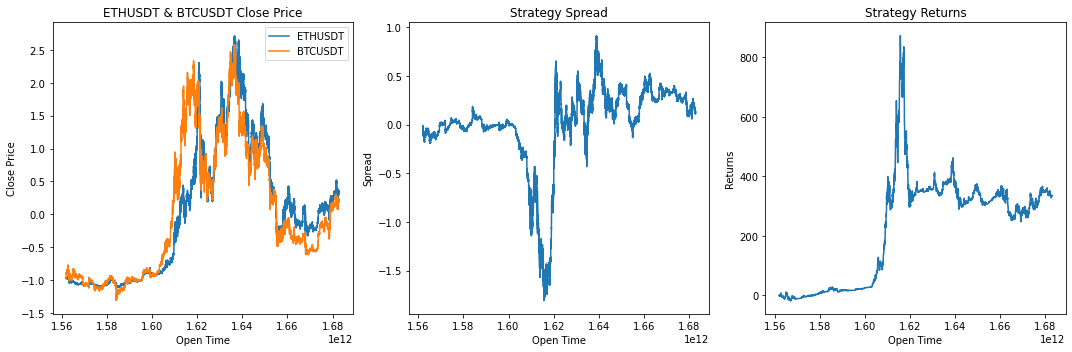

,Variable,Value
0,Volatility,178.203846
1,Max Drawdown,inf
2,Sharpe Ratio,19.879109
3,Sortino Ratio,770.259789
4,Hit Ratio,0.883729
5,Average PnL per Trade,223.158726


In [15]:
backtest = BackTest(df1, 10, pair1, pair2)
df = backtest.test_stats()
df